# DEMO: Running parameter scans

For small examples, i.e. autoencoder instances that utilize training circuits with a small number of parameters, we can plot and visualize loss landscapes by scanning over the circuit parameters.

For this demonstration, we use the two-parameter example shown in [qae_two_qubit_demo.ipynb](https://github.com/hsim13372/QCompress/blob/master/examples/qae_two_qubit_demo.ipynb). Let's first set up this instance.

In [1]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.optimize

from pyquil.gates import *
from pyquil import Program

import sys
sys.path.append('../qcompress')
from qae_engine import *
from utils import *

global pi
pi = np.pi

## QAE Settings

In the cell below, we enter the settings for the QAE. This two-qubit instance utilizes the full training scheme without resetting the input qubits.

__NOTE__: Because QCompress was designed to run on the quantum device (as well as the simulator), we need to anticipate nontrival mappings between abstract qubits and physical qubits. The dictionaries `q_in`,  `q_latent`, and `q_refresh` are abstract-to-physical qubit mappings for the input, latent space, and refresh qubits respectively. A cool plug-in/feature to add would be to have an automated "qubit mapper" to determine the optimal or near-optimal abstract-to-physical qubit mappings for a particular QAE instance.

In [2]:
### QAE setup options

# Abstract-to-physical qubit mapping
q_in = {'q0': 0, 'q1': 1} # Input qubits
q_latent = {'q1': 1}      # Latent space qubits
q_refresh = {'q2': 2}     # Refresh qubits

# Training scheme setup: Full without reset feature
trash_training = False
reset = False

# Simulator settings
cxn_setting = '9q-generic-qvm'
n_shots = 5000

## Data preparation circuits

To prepare the quantum data, we define the state preparation circuits (and their daggered circuits). In this particular example, we will generate the data by scanning over various values of `phi`. 

In [3]:
def _state_prep_circuit(phi, qubit_indices):
    """
    Returns parametrized state preparation circuit.
    We will vary over phi to generate the data set.
    
    :param phi: (list or numpy.array, required) List or array of data generation parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: State preparation circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(RY(phi[0], qubit_indices[1]))
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    return circuit

def _state_prep_circuit_dag(phi, qubit_indices):
    """
    Returns the daggered version of the state preparation circuit.
    
    :param phi: (list or numpy.array, required) List or array of data generation parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: State un-preparation circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    circuit += Program(RY(-phi[0], qubit_indices[1]))
    return circuit

## Qubit labeling

In the cell below, we produce lists of __ordered__ physical qubit indices involved in the compression and recovery maps of the quantum autoencoder. Depending on the training and reset schemes, we may use different qubits for the compression vs. recovery.

In [4]:
compression_indices = order_qubit_labels(q_in).tolist()

q_out = merge_two_dicts(q_latent, q_refresh)
recovery_indices = order_qubit_labels(q_out).tolist()

if not reset:
    recovery_indices = recovery_indices[::-1]

print("Physical qubit indices for compression : {0}".format(compression_indices))
print("Physical qubit indices for recovery    : {0}".format(recovery_indices))

Physical qubit indices for compression : [0, 1]
Physical qubit indices for recovery    : [2, 1]


For the full training scheme with no resetting feature, this will require the three total qubits. 

The first two qubits (`q0`, `q1`) will be used to encode the quantum data. `q1` will then be used as the latent space qubit, meaning our objective will be to reward the training conditions that "push" the information to the latent space qubit. Then, a refresh qubit, `q2`, is added to recover the original data.

## Data generation

After determining the qubit mapping, we add this physical qubit information to the state preparation circuits and store the "mapped" circuits.

In [5]:
# Lists to store state preparation circuits
list_SP_circuits = []
list_SP_circuits_dag = []

phi_list = np.linspace(-pi/2., pi/2., 40)

for angle in phi_list:

    # Map state prep circuits
    state_prep_circuit = _state_prep_circuit([angle], compression_indices)
    
    # Map daggered state prep circuits
    if reset:
        state_prep_circuit_dag = _state_prep_circuit_dag([angle], compression_indices)
    else:
        state_prep_circuit_dag = _state_prep_circuit_dag([angle], recovery_indices)

    # Store mapped circuits
    list_SP_circuits.append(state_prep_circuit)
    list_SP_circuits_dag.append(state_prep_circuit_dag)

## Training circuit preparation

In this step, we choose a parametrized quantum circuit that will be trained to compress then recover the input data set.

__NOTE__: This is a simple one-parameter training circuit.

In [6]:
def _training_circuit(theta, qubit_indices):
    """
    Returns parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(RY(-theta[0]/2, qubit_indices[0]))
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    return circuit

def _training_circuit_dag(theta, qubit_indices):
    """
    Returns the daggered parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Daggered training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(CNOT(qubit_indices[1], qubit_indices[0]))
    circuit += Program(RY(theta[0]/2, qubit_indices[0]))
    return circuit

As was done for the state preparation circuits, we also map the training circuits with physical qubits we want to use.

In [7]:
training_circuit = lambda param : _training_circuit(param, compression_indices)

if reset:
    training_circuit_dag = lambda param : _training_circuit_dag(param, compression_indices)
else:
    training_circuit_dag = lambda param : _training_circuit_dag(param, recovery_indices)

## Define the QAE instance

Here, we initialize a QAE instance. This is where the user can decide which optimizer to use, etc. For this demo, we use the default COBYLA optimizer.

In [8]:
qae = quantum_autoencoder(state_prep_circuits=list_SP_circuits,
                          training_circuit=training_circuit,
                          q_in=q_in,
                          q_latent=q_latent,
                          q_refresh=q_refresh,
                          state_prep_circuits_dag=list_SP_circuits_dag,
                          training_circuit_dag=training_circuit_dag,
                          trash_training=trash_training,
                          reset=reset,
                          n_shots=n_shots, 
                          print_interval=1)

After defining the instance, we set up the Forest connection (in this case, a simulator) and split the data set.

In [9]:
qae.setup_forest_cxn(cxn_setting)

In [10]:
qae.train_test_split(train_indices=[1, 31, 16, 7, 20, 23, 9, 17])

In [11]:
print(qae)

QCompress Setting
QAE type: 2-1-2
Data size: 40
Training set size: 8
Training mode: full cost function
  Reset qubits: False
Parametric compilation: False
Forest connection: 9q-generic-qvm
  Connection type: QVM


## Loss landscape generation and visualization

For small enough examples, we can visualize the loss landscape, which can help us understand where the minimum is. This might be more useful when simulating a noisy version of the autoencoder.

In [12]:
# Collect loss landscape data (scan over various values of theta)
theta_scan = np.linspace(-pi, pi, 30)
training_losses = []

for angle in theta_scan:
    print("Theta scan: {}".format(angle))
    angle = [angle]
    training_loss = qae.compute_loss_function(angle)
    training_losses.append(training_loss)

Theta scan: -3.141592653589793
Iter    0 Mean Loss: -0.4098000
Theta scan: -2.9249310912732556
Iter    1 Mean Loss: -0.4571750
Theta scan: -2.708269528956718
Iter    2 Mean Loss: -0.5115250
Theta scan: -2.4916079666401805
Iter    3 Mean Loss: -0.5770750
Theta scan: -2.2749464043236434
Iter    4 Mean Loss: -0.6306000
Theta scan: -2.058284842007106
Iter    5 Mean Loss: -0.6881000
Theta scan: -1.8416232796905683
Iter    6 Mean Loss: -0.7430500
Theta scan: -1.624961717374031
Iter    7 Mean Loss: -0.7938500
Theta scan: -1.4083001550574934
Iter    8 Mean Loss: -0.8342000
Theta scan: -1.1916385927409558
Iter    9 Mean Loss: -0.8798000
Theta scan: -0.9749770304244185
Iter   10 Mean Loss: -0.9194500
Theta scan: -0.758315468107881
Iter   11 Mean Loss: -0.9506500
Theta scan: -0.5416539057913434
Iter   12 Mean Loss: -0.9741250
Theta scan: -0.3249923434748059
Iter   13 Mean Loss: -0.9903000
Theta scan: -0.10833078115826877
Iter   14 Mean Loss: -0.9990000
Theta scan: 0.10833078115826877
Iter   15 Me

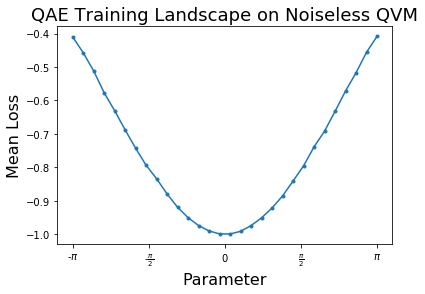

In [13]:
# Visualize loss landscape
fig = plt.figure(figsize=(6, 4))
plt.plot(theta_scan, np.array(training_losses), '.-')
plt.title("QAE Training Landscape on Noiseless QVM", fontsize=18)
plt.xlabel("Parameter", fontsize=16)
plt.ylabel("Mean Loss", fontsize=16)
plt.xticks([-np.pi, -np.pi/2., 0., np.pi/2., np.pi],
           [r"-$\pi$", r"-$\frac{\pi}{2}$", "$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
plt.show()

## A slightly larger example

We've tried doing a similar landscape scan for the hydrogen example shown in [qae_h2_demo.ipynb](https://github.com/hsim13372/QCompress/blob/master/examples/qae_h2_demo.ipynb).

In this hydrogen example, we used a two-parameter training circuit. 

<img src="../images/h2_loss_landscape_full_no_reset_3000_simulated.png" width="600">

This is the loss landscape for the full training case with no reset feature on the noiseless simulator. The number of circuit shots used is 3000. We can see that the minimum is at ($\pi$, $\pi$).